In [429]:
conda install tensorflow

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [430]:
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [431]:
data = pd.read_csv('cpu_memory_usage_v1.csv', header=0)
data

,name,tags,time,pod_name,namespace,cpu_usage_nanocores,memory_working_set_bytes
0,kubernetes_pod_container,NaN,1678492800000000000,drive-az2-prd-69cbb999bc-wklkm,drive,96624523,1337585664
1,kubernetes_pod_container,NaN,1678492800000000000,drive-az2-prd-69cbb999bc-lpr67,drive,89770983,1361653760
2,kubernetes_pod_container,NaN,1678492800000000000,drive-az2-prd-69cbb999bc-sgr2x,drive,77112631,1285890048
3,kubernetes_pod_container,NaN,1678492800000000000,drive-az2-prd-69cbb999bc-2wdsh,drive,35692946,1254232064
4,kubernetes_pod_container,NaN,1678492800000000000,drive-az2-prd-69cbb999bc-chm2j,drive,93409866,1294434304
...,...,...,...,...,...,...,...
231630,kubernetes_pod_container,NaN,1679071890000000000,drive-az2-prd-69cbb999bc-wklkm,drive,12293800,1313955840
231631,kubernetes_pod_container,NaN,1679071890000000000,drive-az2-prd-69cbb999bc-sgr2x,drive,9217571,1338773504
231632,kubernetes_pod_container,NaN,1679071890000000000,drive-az2-prd-69cbb999bc-h8hqh,drive,13224852,1415725056
231633,kubernetes_pod_container,NaN,1679071890000000000,drive-az2-prd-69cbb999bc-b8k2z,drive,18092365,1453850624


In [432]:
data['time'] = pd.to_datetime(data['time'], unit='ns')
data = data.loc[data.pod_name == 'drive-az2-prd-69cbb999bc-lpr67']
date_time = pd.to_datetime(data['time'], format='%Y-%M-%D %H:%M:%S')

In [433]:

data = data.loc[:,['cpu_usage_nanocores', 'memory_working_set_bytes']]

In [434]:
data
date_time

1        2023-03-11 00:00:00
17       2023-03-11 00:00:30
30       2023-03-11 00:01:00
38       2023-03-11 00:01:30
51       2023-03-11 00:02:00
                 ...        
231586   2023-03-17 16:49:30
231588   2023-03-17 16:50:00
231604   2023-03-17 16:50:30
231620   2023-03-17 16:51:00
231629   2023-03-17 16:51:30
Name: time, Length: 19304, dtype: datetime64[ns]

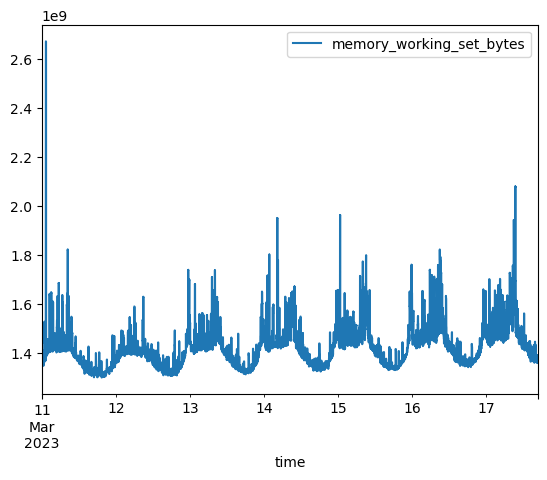

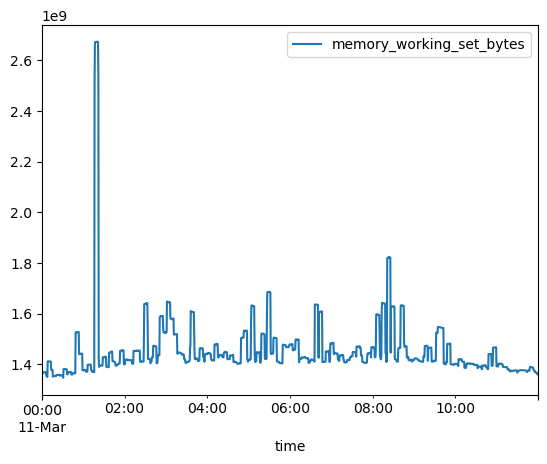

In [435]:
plot_cols = ['memory_working_set_bytes']
plot_features = data[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = data[plot_cols][:1440]
plot_features.index = date_time[:1440]
_ = plot_features.plot(subplots=True)

In [436]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cpu_usage_nanocores,19304.0,7.501222e+07,4.701525e+07,4.568923e+06,2.593340e+07,8.287608e+07,1.138594e+08,2.115833e+08
memory_working_set_bytes,19304.0,1.431759e+09,9.596141e+07,1.299919e+09,1.365593e+09,1.416827e+09,1.465464e+09,2.673066e+09


In [437]:
column_indices = {name: i for i, name in enumerate(data.columns)}

n = len(data)
train_df = data[0:int(n*0.7)]
val_df = data[int(n*0.7):int(n*0.9)]
test_df = data[int(n*0.9):]

num_features = data.shape[1]


In [438]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std
val_df

,cpu_usage_nanocores,memory_working_set_bytes
162142,-1.442240,-0.794435
162154,-1.420089,-0.794481
162166,-1.418691,-0.791823
162178,-1.457375,-0.794481
162190,-1.398495,-0.793152
...,...,...
208405,0.026335,0.378542
208421,0.033833,0.378680
208434,0.162306,0.372860
208442,0.149255,0.369423


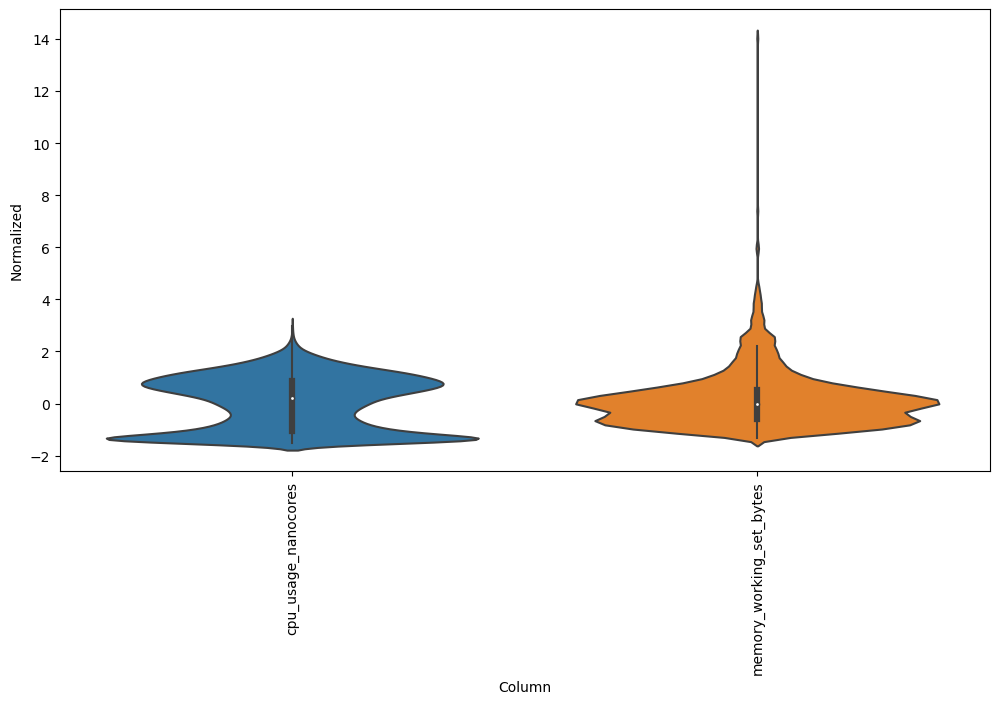

In [439]:
df_std = (data - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(data.keys(), rotation=90)

In [440]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [506]:
train_df

,cpu_usage_nanocores,memory_working_set_bytes
1,0.348295,-0.632071
17,0.660544,-0.632805
30,0.747357,-0.559803
38,0.482558,-0.561819
51,1.562037,-0.554258
...,...,...
162082,-1.397525,-0.841086
162094,-1.427264,-0.840812
162106,-1.397053,-0.839758
162118,-1.205477,-0.794389


In [441]:
w1 = WindowGenerator(input_width=24, label_width=24, shift=1,
                     label_columns=['memory_working_set_bytes'])
w1

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['memory_working_set_bytes']

In [442]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [510]:
w1.total_window_size, train_df.shape

(25, (13512, 2))

In [443]:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 25, 2)
Inputs shape: (3, 24, 2)
Labels shape: (3, 24, 1)


In [444]:
w1.example = example_inputs, example_labels
wide_window.plot(baseline)


In [445]:
def plot(self, model=None, plot_col='memory_working_set_bytes', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

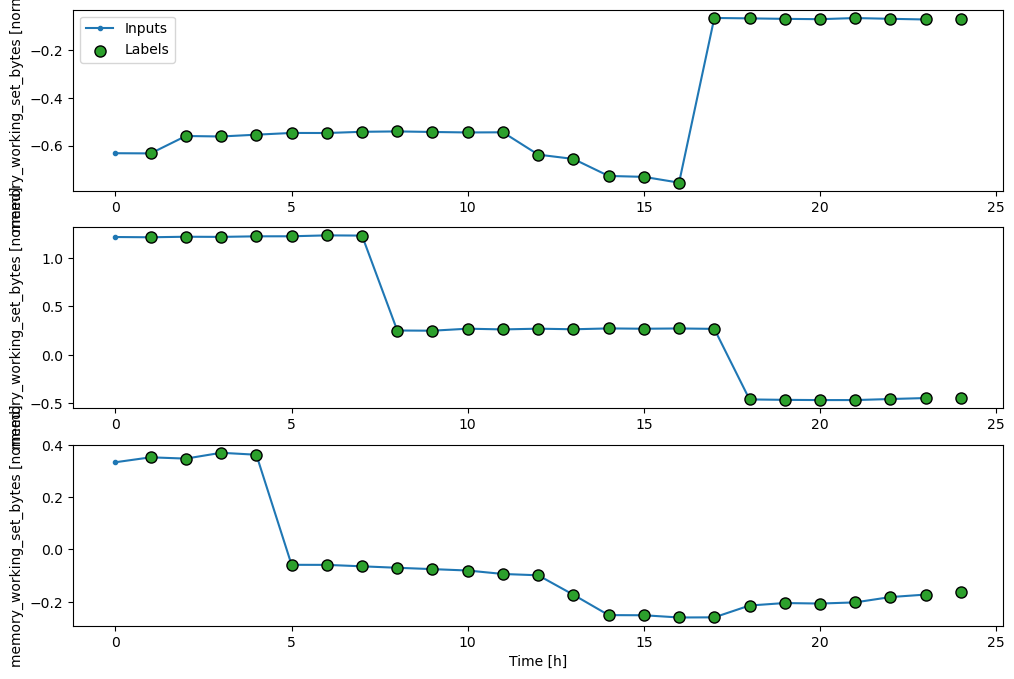

In [446]:
w1.plot()


In [447]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [448]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [449]:
w1.train.element_spec

(TensorSpec(shape=(None, 24, 2), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))

In [450]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 2)
Labels shape (batch, time, features): (32, 24, 1)


In [493]:
single_step_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['memory_working_set_bytes'])
single_step_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['memory_working_set_bytes']

In [452]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 2)
Labels shape (batch, time, features): (32, 24, 1)


In [453]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [505]:
single_step_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['memory_working_set_bytes']

In [454]:
baseline = Baseline(label_index=column_indices['memory_working_set_bytes'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

120/120 [==============================] - 0s 722us/step - loss: 0.0608 - mean_absolute_error: 0.0604


In [455]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['memory_working_set_bytes'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['memory_working_set_bytes']

In [456]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 2)
Output shape: (32, 24, 1)


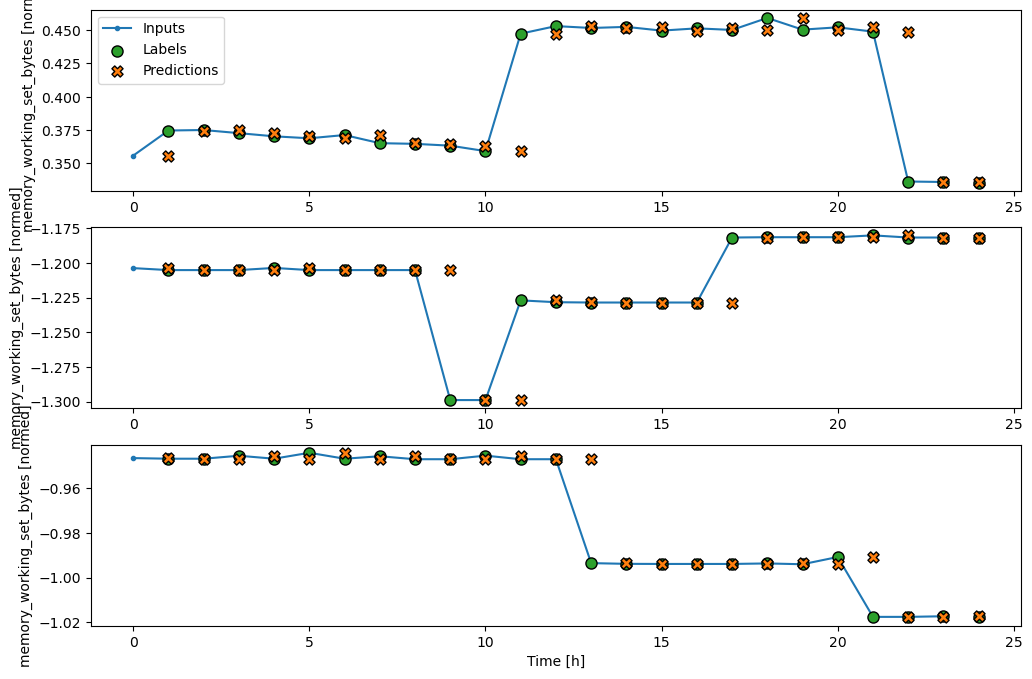

In [457]:
wide_window.plot(baseline)


In [458]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [459]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 24, 2)
Output shape: (32, 24, 1)


In [496]:
import os
from keras.callbacks import EarlyStopping, ModelCheckpoint
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  model_path = 'model'
  filename = os.path.join(model_path, 'tmp_checkpoint_v3.h5')
  checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
  print(window.train)
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping, checkpoint])
  return history

In [497]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

<MapDataset element_spec=(TensorSpec(shape=(None, 24, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>
Epoch 1/20
403/422 [===========================>..] - ETA: 0s - loss: 0.0833 - mean_absolute_error: 0.0851
Epoch 1: val_loss improved from inf to 0.05938, saving model to model/tmp_checkpoint_v3.h5
422/422 [==============================] - 1s 1ms/step - loss: 0.0821 - mean_absolute_error: 0.0849 - val_loss: 0.0594 - val_mean_absolute_error: 0.0913
Epoch 2/20
385/422 [==========================>...] - ETA: 0s - loss: 0.0825 - mean_absolute_error: 0.0855
Epoch 2: val_loss did not improve from 0.05938
422/422 [==============================] - 1s 1ms/step - loss: 0.0821 - mean_absolute_error: 0.0855 - val_loss: 0.0595 - val_mean_absolute_error: 0.0914
Epoch 3/20
412/422 [============================>.] - ETA: 0s - loss: 0.0824 - mean_absolute_error: 0.0855
Epoch 3: val_loss did not improve from 0.05938
120/120 [============================

In [462]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 2)
Output shape: (32, 24, 1)


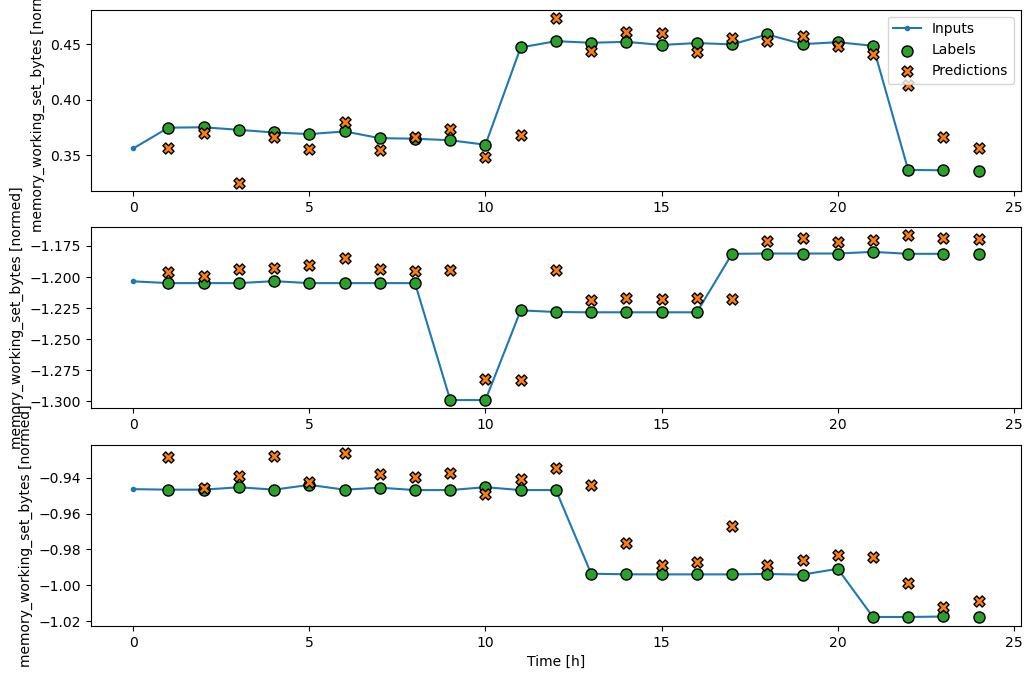

In [463]:
wide_window.plot(linear)

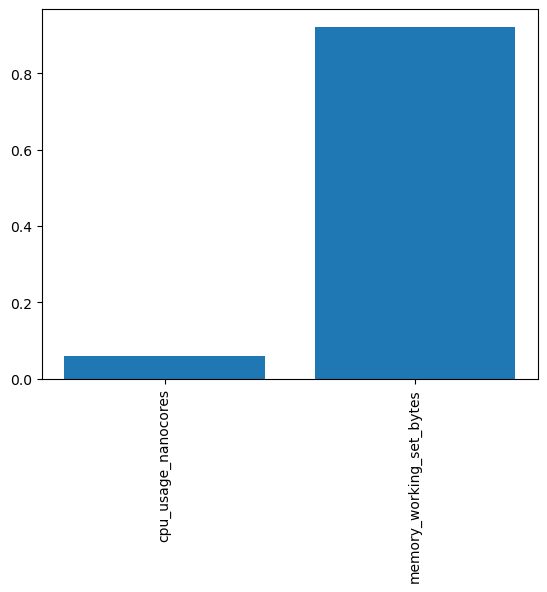

In [464]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [465]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
396/422 [===========================>..] - ETA: 0s - loss: 0.1323 - mean_absolute_error: 0.1202
Epoch 1: val_loss improved from inf to 0.05845, saving model to model/tmp_checkpoint_v3.h5
422/422 [==============================] - 2s 2ms/step - loss: 0.1299 - mean_absolute_error: 0.1185 - val_loss: 0.0585 - val_mean_absolute_error: 0.0864
Epoch 2/20
392/422 [==========================>...] - ETA: 0s - loss: 0.0810 - mean_absolute_error: 0.0873
Epoch 2: val_loss improved from 0.05845 to 0.05772, saving model to model/tmp_checkpoint_v3.h5
422/422 [==============================] - 1s 2ms/step - loss: 0.0822 - mean_absolute_error: 0.0875 - val_loss: 0.0577 - val_mean_absolute_error: 0.0885
Epoch 3/20
404/422 [===========================>..] - ETA: 0s - loss: 0.0816 - mean_absolute_error: 0.0868
Epoch 3: val_loss did not improve from 0.05772
422/422 [==============================] - 1s 2ms/step - loss: 0.0820 - mean_absolute_error: 0.0871 - val_loss: 0.0582 - val_mean_absolute_e

In [466]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['memory_working_set_bytes'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['memory_working_set_bytes']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

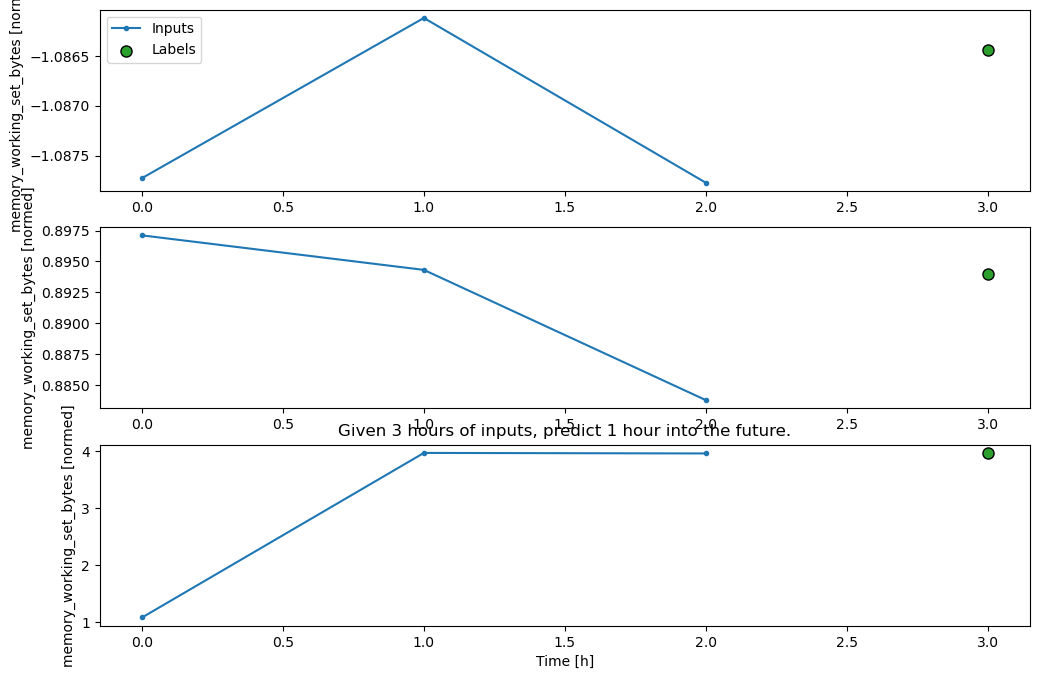

In [467]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

In [468]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [469]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 2)
Output shape: (32, 1, 1)


In [470]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

121/121 [==============================] - 0s 1ms/step - loss: 0.0611 - mean_absolute_error: 0.1028


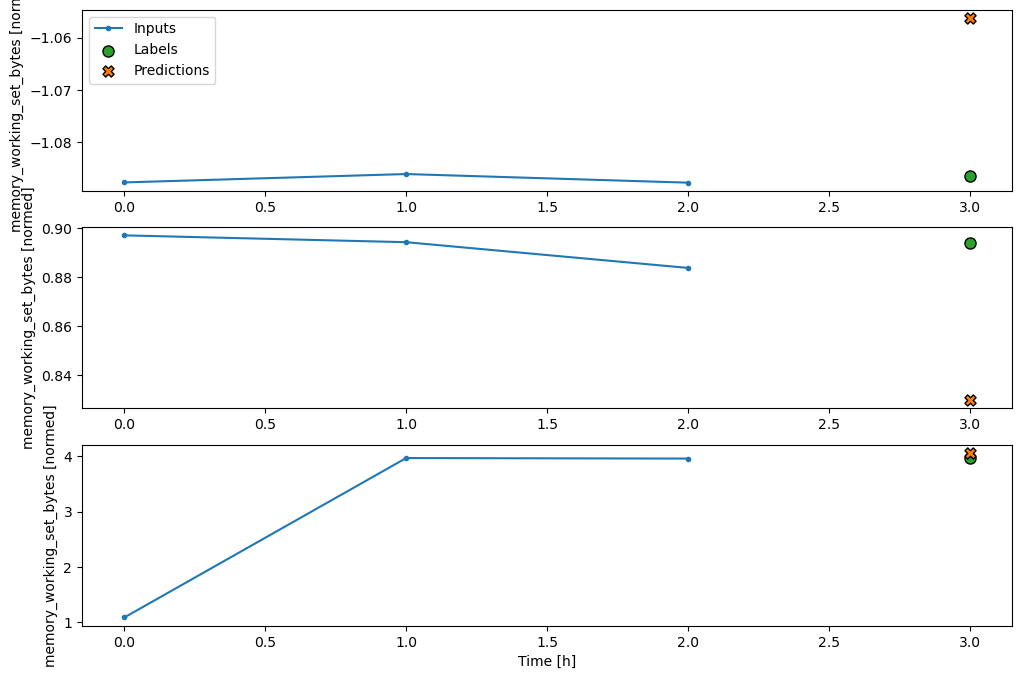

In [471]:
conv_window.plot(multi_step_dense)

In [472]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 2)

ValueError:Exception encountered when calling layer "sequential_33" "                 f"(type Sequential).

Input 0 of layer "dense_59" is incompatible with the layer: expected axis -1 of input shape to have value 6, but received input with shape (32, 48)

Call arguments received by layer "sequential_33" "                 f"(type Sequential):
  • inputs=tf.Tensor(shape=(32, 24, 2), dtype=float32)
  • training=None
  • mask=None


In [473]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [474]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 2)
Output shape: (32, 1, 1)


In [475]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

121/121 [==============================] - 0s 1ms/step - loss: 0.0651 - mean_absolute_error: 0.1128


In [476]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 2)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [477]:
LABEL_WIDTH = 96
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['memory_working_set_bytes'])

wide_conv_window

Total window size: 99
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98]
Label column name(s): ['memory_working_set_bytes']

In [478]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 98, 2)
Labels shape: (32, 96, 1)
Output shape: (32, 96, 1)


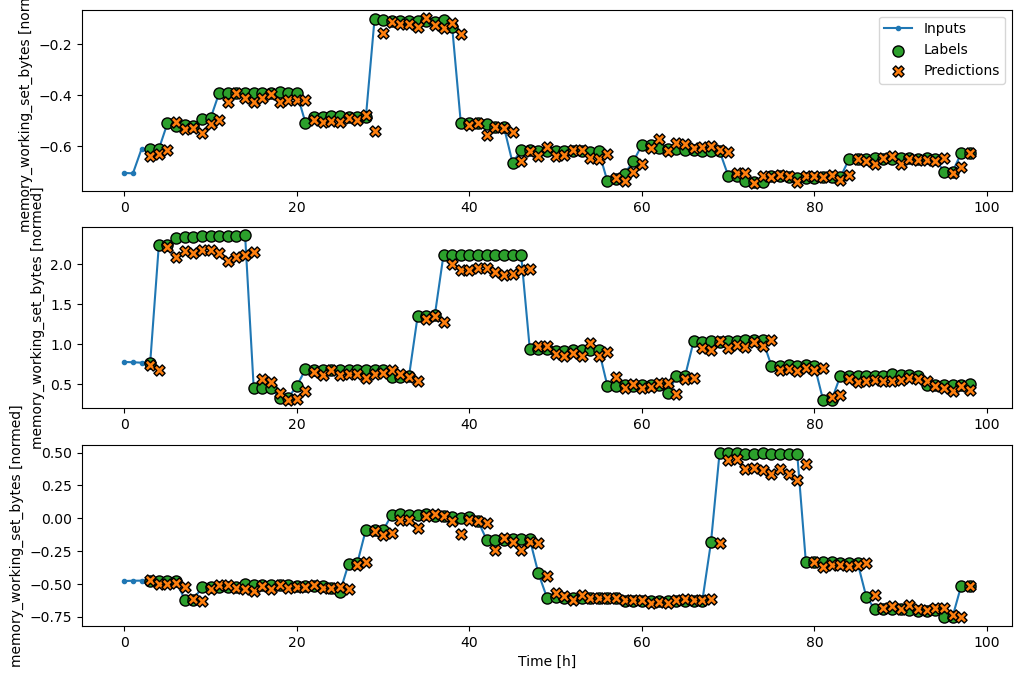

In [479]:
wide_conv_window.plot(conv_model)

In [480]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [481]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 2)
Output shape: (32, 24, 1)


In [482]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

120/120 [==============================] - 0s 1ms/step - loss: 0.0574 - mean_absolute_error: 0.0956


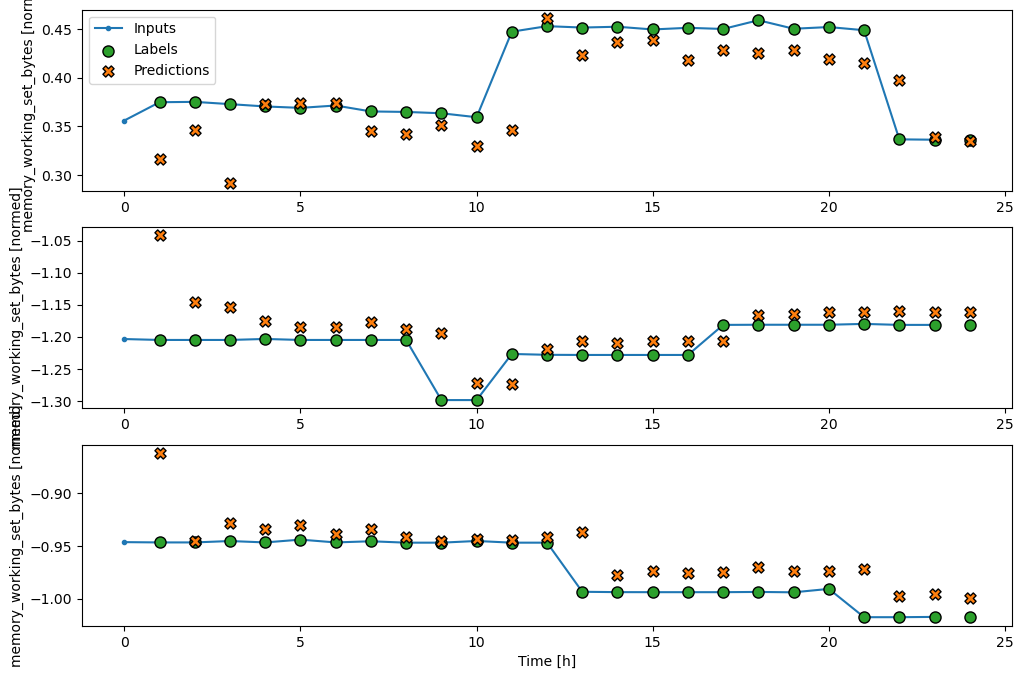

In [483]:
wide_window.plot(lstm_model)

In [484]:
gru_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.GRU(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [485]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', gru_model(wide_window.example[0]).shape)

Input shape: (32, 24, 2)
Output shape: (32, 24, 1)


In [486]:
history = compile_and_fit(gru_model, wide_window)

IPython.display.clear_output()
val_performance['GRU'] = gru_model.evaluate(wide_window.val)
performance['GRU'] = gru_model.evaluate(wide_window.test, verbose=0)

120/120 [==============================] - 0s 1ms/step - loss: 0.0606 - mean_absolute_error: 0.0999


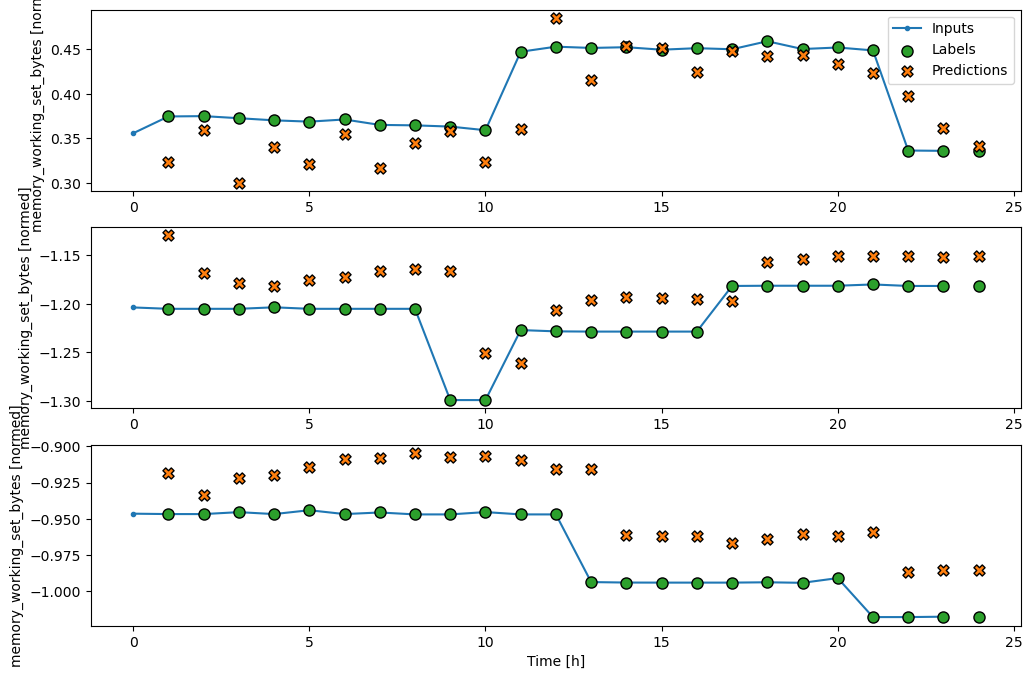

In [487]:
wide_window.plot(gru_model)

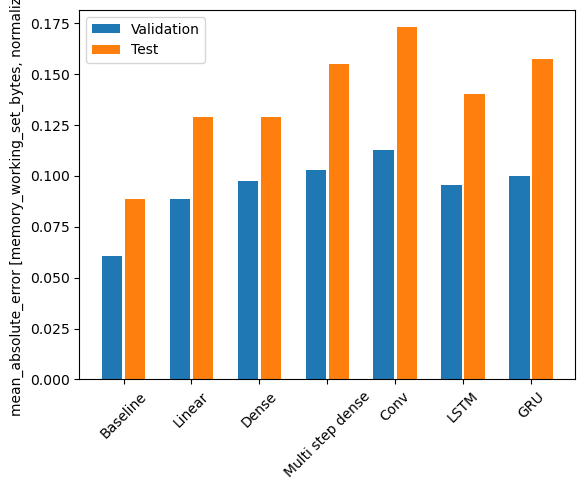

In [488]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [memory_working_set_bytes, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [489]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0886
Linear      : 0.1288
Dense       : 0.1289
Multi step dense: 0.1549
Conv        : 0.1728
LSTM        : 0.1400
GRU         : 0.1576
